# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import test.project_tests as t
import pickle
import seaborn as sns

#Custom NLP Transformers and Estimators
import nlp_estimators
from nltk import WordNetLemmatizer

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [107]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [108]:
articles_per_user = df.groupby('email').article_id.count().reset_index(name='num_articles')

In [109]:
articles_per_user.head()

,email,num_articles
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


In [110]:
articles_per_user.describe()

,num_articles
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


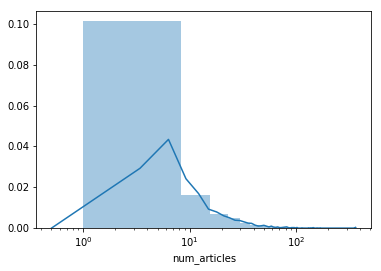

In [111]:
g = sns.distplot(articles_per_user.num_articles)
g.set_xscale("log")

In [112]:
# Fill in the median and maximum number of user_article interactios below

median_val = articles_per_user.describe().num_articles.loc['50%']# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = articles_per_user.describe().num_articles.loc['max']# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [113]:
# Find and explore duplicate articles
duplicate_articles = df_content[df_content.duplicated(['article_id'])]

In [114]:
print(duplicate_articles.shape[0])
duplicate_articles.head(10)

5


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [115]:
# Remove any rows that have the same article_id - only keep the first
clean_articles = df_content.drop_duplicates(['article_id'])
clean_articles['doc_description'] = clean_articles['doc_description'].astype(str)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
clean_articles.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [117]:
interactions_per_article = df.groupby('article_id').email.count().reset_index(name='num_interactions')
interactions_per_article = interactions_per_article[interactions_per_article['num_interactions'] > 0]
interactions_per_article.head()

,article_id,num_interactions
0,0.0,14
1,2.0,58
2,4.0,13
3,8.0,85
4,9.0,10


In [118]:
unique_articles = interactions_per_article.shape[0]# The number of unique articles that have at least one interaction
total_articles = clean_articles.shape[0] # The number of unique articles on the IBM platform
unique_users = df.email.dropna().unique().shape[0]# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [119]:
most_viewed_article = interactions_per_article[interactions_per_article['num_interactions'] == interactions_per_article.num_interactions.max()]

In [120]:
most_viewed_article

,article_id,num_interactions
699,1429.0,937


In [121]:
most_viewed_article_id = str(most_viewed_article.article_id.values[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = most_viewed_article.num_interactions.values[0] # The most viewed article in the dataset was viewed how many times?

In [122]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [123]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [124]:
unique_articles

714

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [125]:
interactions_per_article.sort_values('num_interactions', ascending=False).article_id.values[:5]

array([ 1429.,  1330.,  1431.,  1427.,  1364.])

In [126]:
df.groupby(['article_id','title']).user_id.count().reset_index(name='num_interactions').sort_values('num_interactions', 
                                                        ascending=False) \
                                            .title.values[:5].tolist()

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [127]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    interactions_per_article = df.groupby(['article_id','title']).user_id.count().reset_index(name='num_interactions')
    top_articles = interactions_per_article.sort_values('num_interactions', 
                                                        ascending=False) \
                                            .title.values[:n].tolist()
    
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    interactions_per_article = df.assign(article_id = lambda x: x.article_id.astype(str)) \
                                .groupby(['article_id','title']).user_id.count() \
                                .reset_index(name='num_interactions')
    top_articles = interactions_per_article.sort_values('num_interactions', 
                                                        ascending=False) \
                                            .article_id.values[:n].tolist()
 
    return top_articles # Return the top article ids

In [128]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [129]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [130]:
test_df = df.head(10)
test_df['interaction'] = 1
test_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,article_id,title,user_id,interaction
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,1
1,1314.0,healthcare python streaming application demo,2,1
2,1429.0,use deep learning for image classification,3,1
3,1338.0,ml optimization using cognitive assistant,4,1
4,1276.0,deploy your python model as a restful api,5,1
5,1432.0,visualize data with the matplotlib library,6,1
6,1429.0,use deep learning for image classification,7,1
7,593.0,upload files to ibm data science experience us...,8,1
8,1314.0,healthcare python streaming application demo,9,1
9,1185.0,classify tumors with machine learning,10,1


In [131]:
test_mat = test_df.groupby(['user_id', 'article_id'])['interaction'].min().unstack().fillna(0)

In [132]:
test_mat.shape

(10, 8)

In [133]:
test_mat

article_id,593.0,1185.0,1276.0,1314.0,1338.0,1429.0,1430.0,1432.0
user_id,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [134]:
test_mat.sum(axis=1)

user_id
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
dtype: float64

In [135]:
test_mat.iloc[2,:]

article_id
593.0     0.0
1185.0    0.0
1276.0    0.0
1314.0    0.0
1338.0    0.0
1429.0    1.0
1430.0    0.0
1432.0    0.0
Name: 3, dtype: float64

In [136]:
test_mat.T

user_id,1,2,3,4,5,6,7,8,9,10
article_id,,,,,,,,,,
593.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1185.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1276.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1314.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1338.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1429.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1430.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1432.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [137]:
test_sim = np.dot(test_mat.iloc[1,:],test_mat.T)
test_sim

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

In [138]:
test_sim.argsort()[::-1]

array([8, 1, 9, 7, 6, 5, 4, 3, 2, 0])

In [139]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df['interaction'] = 1
    user_item = df.groupby(['user_id', 'article_id'])['interaction'].min().unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [140]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [141]:
users_similarity = np.dot(user_item.iloc[0,:],user_item.T)

In [142]:
user_item.sum(axis=1)[1]

36.0

In [143]:
print(users_similarity.shape)
print(type(users_similarity))
users_similarity

(5149,)
<class 'numpy.ndarray'>


array([ 36.,   2.,   6., ...,   0.,   0.,   0.])

In [144]:
users_similarity[~np.isnan(users_similarity)].shape[0]

5149

In [145]:
most_similar_users = users_similarity.argsort()[::-1] + 1
most_similar_users

array([   1, 3933,   23, ..., 2916, 2911, 2575])

In [146]:
np.delete(most_similar_users, 1)

array([   1,   23, 3782, ..., 2916, 2911, 2575])

In [147]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    users_similarity = np.dot(user_item.iloc[user_id-1,:],user_item.T)

    # sort by similarity
    # create list of just the ids
    most_similar_users = users_similarity.argsort()[::-1] + 1
   
    # remove the own user's id
    most_similar_users = most_similar_users[most_similar_users != user_id]
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [148]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [149]:
user_articles = user_item.iloc[0,:]
user_articles[user_articles > 0].keys().values

array([   43.,   109.,   151.,   268.,   310.,   329.,   346.,   390.,
         494.,   525.,   585.,   626.,   668.,   732.,   768.,   910.,
         968.,   981.,  1052.,  1170.,  1183.,  1185.,  1232.,  1293.,
        1305.,  1363.,  1368.,  1391.,  1400.,  1406.,  1427.,  1429.,
        1430.,  1431.,  1436.,  1439.])

In [150]:
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


In [151]:
df.describe()

,article_id,user_id,interaction
count,45993.000000,45993.000000,45993.0
mean,908.846477,2300.918314,1.0
std,486.647866,1712.658385,0.0
min,0.000000,1.000000,1.0
25%,460.000000,621.000000,1.0
50%,1151.000000,2330.000000,1.0
75%,1336.000000,3835.000000,1.0
max,1444.000000,5149.000000,1.0


In [152]:
clean_articles.set_index('article_id')

,doc_body,doc_description,doc_full_name,doc_status
article_id,,,,
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live


In [153]:
user_item.iloc[0,:].keys()

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0,
              1443.0, 1444.0],
             dtype='float64', name='article_id', length=714)

In [154]:
unique_articles = df[['article_id','title']].drop_duplicates() \
                        .assign(article_id = lambda x: x.astype(str)) \
                        .set_index('article_id')

In [155]:
unique_articles.head()

,title
article_id,
1430.0,"using pixiedust for fast, flexible, and easier..."
1314.0,healthcare python streaming application demo
1429.0,use deep learning for image classification
1338.0,ml optimization using cognitive assistant
1276.0,deploy your python model as a restful api


In [156]:
article_ids = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
article_names = unique_articles.loc[article_ids,:].title.values

In [157]:
article_names

array(['using deep learning to reconstruct high-resolution audio',
       'build a python app on the streaming analytics service',
       'gosales transactions for naive bayes model',
       'healthcare python streaming application demo',
       'use r dataframes & ibm watson natural language understanding',
       'use xgboost, scikit-learn & ibm watson machine learning apis'], dtype=object)

In [158]:
clean_articles

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


In [159]:
unique_articles

,title
article_id,
1430.0,"using pixiedust for fast, flexible, and easier..."
1314.0,healthcare python streaming application demo
1429.0,use deep learning for image classification
1338.0,ml optimization using cognitive assistant
1276.0,deploy your python model as a restful api
1432.0,visualize data with the matplotlib library
593.0,upload files to ibm data science experience us...
1185.0,classify tumors with machine learning
993.0,configuring the apache spark sql context


In [160]:
unique_articles.loc[['1014.0','1024.0'],:].title.values

array([ '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
       'using deep learning to reconstruct high-resolution audio'], dtype=object)

In [161]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    unique_articles = df[['article_id','title']].drop_duplicates() \
                        .assign(article_id = lambda x: x.article_id.astype(str)) \
                        .set_index('article_id')
    article_names = unique_articles.loc[article_ids,:].title.values
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_row = user_item.iloc[user_id - 1,:]
    article_ids = user_row[user_row > 0].keys().astype(str).values
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = np.array([])
    user_seen_ids = get_user_articles(user_id)[0]
    most_similar_users = find_similar_users(user_id)
    for similar_user in most_similar_users:
        sim_user_seen_ids = get_user_articles(similar_user)[0]
        sim_user_recs = np.setdiff1d(sim_user_seen_ids,user_seen_ids,assume_unique=True)
        recs = np.unique(np.concatenate([recs,sim_user_recs]))
    
        if (len(recs) > m):
            recs = recs[:m]
            break
    
    return recs # return your recommendations for this user_id    

In [162]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['recommender systems: approaches & algorithms',
       '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
       'data tidying in data science experience',
       'a tensorflow regression model to predict house values',
       '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
       'airbnb data for analytics: mallorca reviews',
       'airbnb data for analytics: vancouver listings',
       'analyze facebook data using ibm watson and watson studio',
       'analyze accident reports on amazon emr spark',
       'analyze energy consumption in buildings'], dtype=object)

In [163]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [164]:
users_similarity = np.dot(user_item.iloc[0,:],user_item.T)
users_similarity

array([ 36.,   2.,   6., ...,   0.,   0.,   0.])

In [165]:
user_item.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=5149)

In [166]:
df.head()

,article_id,title,user_id,interaction
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,1
1,1314.0,healthcare python streaming application demo,2,1
2,1429.0,use deep learning for image classification,3,1
3,1338.0,ml optimization using cognitive assistant,4,1
4,1276.0,deploy your python model as a restful api,5,1


In [167]:
users_interactions = df.groupby('user_id').interaction.sum().reset_index() \
.rename(index=str, columns={'interaction':'num_interactions','user_id':'neighbor_id'})
users_interactions.head()

,neighbor_id,num_interactions
0,1,47
1,2,6
2,3,82
3,4,45
4,5,5


In [168]:
user_id = 1

In [169]:
neighbors_df = pd.DataFrame({'neighbor_id' : user_item.index, 
              'similarity' : users_similarity}) \
    .merge(users_interactions, on='neighbor_id') \
    .sort_values(['similarity','num_interactions'], ascending=False) \
    .query('neighbor_id != @user_id')
neighbors_df.head()

,neighbor_id,similarity,num_interactions
3932,3933,35.0,45
22,23,17.0,364
3781,3782,17.0,363
202,203,15.0,160
4458,4459,15.0,158


In [170]:
interactions_per_article = df.groupby(['article_id','title']).user_id.count().reset_index(name='num_interactions')

In [171]:
interactions_per_article.head()

,article_id,title,num_interactions
0,0.0,detect malfunctioning iot sensors with streami...,14
1,2.0,"this week in data science (april 18, 2017)",58
2,4.0,analyze ny restaurant data using spark in dsx,13
3,8.0,data science bowl 2017,85
4,9.0,3992 using apache spark to predict attack v...,10


In [172]:
interactions_per_article.dtypes

article_id          float64
title                object
num_interactions      int64
dtype: object

In [173]:
test_article_ids = [0,2,4]

In [174]:
interactions_per_article[interactions_per_article['article_id'].isin(test_article_ids)].sort_values('num_interactions', ascending=False)

,article_id,title,num_interactions
1,2.0,"this week in data science (april 18, 2017)",58
0,0.0,detect malfunctioning iot sensors with streami...,14
2,4.0,analyze ny restaurant data using spark in dsx,13


In [175]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    neighbors_ids = user_item.index
    users_similarity = np.dot(user_item.iloc[user_id-1,:],user_item.T)
    users_interactions = df.groupby('user_id').interaction.sum() \
                            .reset_index() \
                            .rename(index=str, 
                                    columns={'interaction':'num_interactions',
                                             'user_id':'neighbor_id'})

    # create dataframe with neighbor ids, similarity and number of interactions
    # sort by similarity and number of interactions
    # remove the own user's id
    neighbors_df = pd.DataFrame({'neighbor_id' : user_item.index, 
              'similarity' : users_similarity}) \
                    .merge(users_interactions, on='neighbor_id') \
                    .sort_values(['similarity','num_interactions'], ascending=False) \
                    .query('neighbor_id != @user_id') 
   
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, verbose=False):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    verbose - (boolean) whether the output should be verbose (print logs)
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = np.array([])
    interactions_per_article = df.groupby(['article_id','title']).user_id.count() \
                                .reset_index(name='num_interactions') \
                                .assign(article_id = lambda x: x.article_id.astype(str))
    user_seen_ids = get_user_articles(user_id)[0]
    most_similar_users = get_top_sorted_users(user_id).neighbor_id
    for similar_user in most_similar_users:
        if verbose: print('similar_user:', similar_user)
        sim_user_seen_ids = get_user_articles(similar_user)[0]
        sim_user_recs = np.setdiff1d(sim_user_seen_ids,
                                     np.concatenate([user_seen_ids,recs]),assume_unique=True)
        if verbose: print('sim_user_recs', sim_user_recs, sim_user_recs.shape[0])
        ordered_sim_user_recs = interactions_per_article[interactions_per_article['article_id']\
                                                         .isin(sim_user_recs)]\
                                    .sort_values('num_interactions', ascending=False).article_id.values
        if verbose: print('ordered_sim_user_recs', ordered_sim_user_recs, ordered_sim_user_recs.shape[0])
        if verbose: print('recs before', recs, recs.shape[0])
        recs = pd.unique(np.concatenate([recs,ordered_sim_user_recs]))
        if verbose: print('recs after', recs, recs.shape[0])
    
        if (len(recs) > m):
            recs = recs[:m]
            break
            
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [176]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 100, True)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

similar_user: 170
sim_user_recs ['12.0' '109.0' '125.0' '142.0' '164.0' '205.0' '302.0' '336.0' '362.0'
 '465.0' '555.0' '651.0' '681.0' '686.0' '730.0' '761.0' '793.0' '880.0'
 '911.0' '939.0' '981.0' '1024.0' '1085.0' '1150.0' '1151.0' '1152.0'
 '1153.0' '1154.0' '1157.0' '1160.0' '1162.0' '1163.0' '1166.0' '1170.0'
 '1172.0' '1176.0' '1276.0' '1278.0' '1296.0' '1304.0' '1324.0' '1329.0'
 '1330.0' '1331.0' '1335.0' '1336.0' '1338.0' '1346.0' '1351.0' '1354.0'
 '1356.0' '1357.0' '1360.0' '1364.0' '1367.0' '1368.0' '1386.0' '1391.0'
 '1396.0' '1407.0' '1409.0' '1410.0' '1411.0' '1420.0' '1424.0' '1426.0'
 '1427.0' '1433.0' '1444.0'] 69
ordered_sim_user_recs ['1330.0' '1427.0' '1364.0' '1170.0' '1162.0' '1304.0' '1351.0' '1160.0'
 '1354.0' '1368.0' '1338.0' '1336.0' '1172.0' '1276.0' '1163.0' '164.0'
 '681.0' '1360.0' '1396.0' '109.0' '1296.0' '1166.0' '1391.0' '1386.0'
 '1367.0' '1324.0' '1176.0' '12.0' '730.0' '1426.0' '939.0' '1424.0'
 '981.0' '125.0' '1357.0' '1420.0' '1410.0' '651.

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [177]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9]# Find the 10th most similar user to user 131

In [178]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For new users, we cannot use the user_user recommendation functions as they rely on user similarity which is calculated based on previous user-article interactions. As the new user has no previous interaction with articles, they will not work for him.

A better way to make recommendations to such users is to recommend the top articles, based on overall user-article interactions, using the function get_top_articles().

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [179]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(n=10)# Your recommendations here



In [180]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [181]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [182]:
df_content.loc[0,['doc_description','doc_full_name']]

doc_description    Detect bad readings in real time using Python ...
doc_full_name      Detect Malfunctioning IoT Sensors with Streami...
Name: 0, dtype: object

In [183]:
for i in range(10):
    print(df_content.doc_description[i])
    print(df_content.doc_full_name[i])

Detect bad readings in real time using Python and Streaming Analytics.
Detect Malfunctioning IoT Sensors with Streaming Analytics
See the forest, see the trees. Here lies the challenge in both performing and presenting an analysis. As data scientists, analysts, and machine learning engineers faced with fulfilling business obj…
Communicating data science: A guide to presenting your work
Here’s this week’s news in Data Science and Big Data.
This Week in Data Science (April 18, 2017)
Learn how distributed DBs solve the problem of scaling persistent storage, but introduce latency as data size increases and become I/O bound.
DataLayer Conference: Boost the performance of your distributed database
This video demonstrates the power of IBM DataScience Experience using a simple New York State Restaurant Inspections data scenario. 
Analyze NY Restaurant data using Spark in DSX
Using Compose's PostgreSQL data browser.
Browsing PostgreSQL Data with Compose
Upgrading your PostgreSQL deployment to v

In [184]:
user_articles_interactions = df.groupby(['user_id','article_id']).interaction.count().reset_index().sort_values(['user_id','interaction'],ascending=False)
user_articles_interactions.head()

,user_id,article_id,interaction
33681,5149,16.0,1
33680,5148,1160.0,1
33679,5147,233.0,1
33676,5146,1324.0,3
33672,5146,142.0,1


In [185]:
clean_articles.columns

Index(['doc_body', 'doc_description', 'doc_full_name', 'doc_status',
       'article_id'],
      dtype='object')

In [264]:
# Build Similarity Matrix

# Tokenize article descriptions
lemmatizer = WordNetLemmatizer()
articles_tokens = clean_articles[['article_id','doc_description']]

articles_tokens.loc[:,'tokens_str'] = articles_tokens.doc_description.apply(
    lambda x: nlp_estimators.tokenize_to_str(x, lemmatizer))

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [265]:
articles_tokens.doc_description.head()

0    Detect bad readings in real time using Python ...
1    See the forest, see the trees. Here lies the c...
2    Here’s this week’s news in Data Science and Bi...
3    Learn how distributed DBs solve the problem of...
4    This video demonstrates the power of IBM DataS...
Name: doc_description, dtype: object

In [266]:
articles_tokens

,article_id,doc_description,tokens_str
0,0,Detect bad readings in real time using Python ...,detect bad reading real time using python stre...
1,1,"See the forest, see the trees. Here lies the c...",see forest see tree lie challenge performing p...
2,2,Here’s this week’s news in Data Science and Bi...,week news data science big data
3,3,Learn how distributed DBs solve the problem of...,learn distributed db solve problem scaling per...
4,4,This video demonstrates the power of IBM DataS...,video demonstrates power ibm datascience exper...
5,5,Using Compose's PostgreSQL data browser.,using compose postgresql data browser
6,6,Upgrading your PostgreSQL deployment to versio...,upgrading postgresql deployment version 9 5 po...
7,7,For a company like Slack that strives to be as...,company like slack strives data driven possibl...
8,8,Kaggle is your home for data science. Learn ne...,kaggle home data science learn new skill build...
9,9,[A version of this post appears on the O’Reill...,version post appears reilly radar reilly data ...


In [267]:
print(articles_tokens.shape)

(1051, 3)


In [268]:
w2v_articles_model = nlp_estimators.TfidfEmbeddingTrainVectorizer(num_dims=300)

In [269]:
w2v_articles_model.fit(articles_tokens.tokens_str.values, None)

TfidfEmbeddingTrainVectorizer(num_dims=300,
               word2vec_model=<gensim.models.word2vec.Word2Vec object at 0x7fb1ac2621d0>)

In [270]:
articles_embeddings = w2v_articles_model.transform(articles_tokens.tokens_str.values)

In [271]:
articles_embeddings.shape

(1051, 300)

In [272]:
np.array(articles_embeddings[0,:])

array([  2.60708999e-04,  -2.75875820e-04,  -1.51128552e-04,
         1.75917303e-04,  -2.62617414e-05,   4.93781234e-04,
        -2.13221996e-04,   2.88512470e-04,  -2.67978874e-04,
         1.78049057e-04,   1.22651778e-04,  -1.76579095e-04,
         4.21499833e-04,  -3.24343389e-04,  -1.07824846e-04,
        -3.77950382e-05,  -2.93885212e-04,  -3.26366280e-04,
         1.60570853e-05,  -1.40737786e-04,  -1.94948560e-04,
        -1.55786882e-04,  -9.15642086e-05,  -3.17094236e-04,
        -4.14331502e-04,  -1.33498415e-05,   2.31759084e-04,
         3.26631671e-05,  -2.34192499e-04,  -2.28763340e-04,
         3.49463226e-04,   2.25231095e-04,  -6.33277887e-05,
        -4.46521823e-04,   2.79126834e-05,   2.45643809e-04,
        -4.30247776e-04,  -1.44359410e-05,  -3.40813393e-04,
        -3.10753763e-04,   1.44841673e-04,   2.48528289e-04,
         2.14781816e-04,   1.83456024e-04,  -5.40669571e-05,
         2.69239739e-04,  -2.13408293e-05,  -3.38686339e-04,
         2.05914475e-04,

In [273]:
from sklearn.metrics.pairwise import cosine_similarity
article_sim_matrix = cosine_similarity(articles_embeddings,articles_embeddings)

In [274]:
print(article_sim_matrix.shape)
print(article_sim_matrix)

(1051, 1051)
[[ 1.          0.89260991  0.85136431 ...,  0.90637616  0.83340432
   0.91839827]
 [ 0.89260991  1.          0.82532192 ...,  0.86487499  0.77310817
   0.91136227]
 [ 0.85136431  0.82532192  1.         ...,  0.73795058  0.83964449
   0.82942558]
 ..., 
 [ 0.90637616  0.86487499  0.73795058 ...,  1.          0.73814724
   0.84457736]
 [ 0.83340432  0.77310817  0.83964449 ...,  0.73814724  1.          0.78341064]
 [ 0.91839827  0.91136227  0.82942558 ...,  0.84457736  0.78341064  1.        ]]


In [323]:
article_id = 10

In [324]:
article_index = articles_tokens[articles_tokens['article_id'] == article_id].index.values[0]
article_index

10

In [277]:
article_sim_row = article_sim_matrix[article_index,]
article_sim_row

array([ 0.91099456,  0.92043368,  0.85107259, ...,  0.85049503,
        0.85126576,  0.93771875])

In [278]:
article_sim_row[:10]

array([ 0.91099456,  0.92043368,  0.85107259,  1.        ,  0.9489999 ,
        0.81747738,  0.77441643,  0.94891866,  0.91817132,  0.90954981])

In [282]:
similar_articles = (article_sim_row >= 0.95).nonzero()[0]
similar_articles

array([   3,   18,   82,  307,  333,  428,  524,  535,  555,  689,  743,
        752,  754,  970,  997, 1031, 1043])

In [280]:
np.delete((article_sim_row >= 0.95).nonzero()[0],article_sim_row)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  """Entry point for launching an IPython kernel.


array([  82,  307,  333,  428,  524,  535,  555,  689,  743,  752,  754,
        970,  997, 1031, 1043])

In [284]:
article_sim_row.argsort()[::-1]

array([  3, 689, 524, ..., 354, 916, 765])

In [302]:
mask = (article_sim_row > 0.95)
mask

array([False, False, False, ..., False, False, False], dtype=bool)

In [303]:
sort_idx = article_sim_row.argsort()[::-1]

In [304]:
out = sort_idx[mask[sort_idx]]

In [309]:
out

array([   3,  689,  524,  428,   18,  333,  970, 1043,  754,  555,   82,
        307,  752,  743, 1031,  535,  997])

In [310]:
out[out != article_index]

array([ 689,  524,  428,   18,  333,  970, 1043,  754,  555,   82,  307,
        752,  743, 1031,  535,  997])

In [311]:
df.describe()

,article_id,user_id,interaction
count,45993.000000,45993.000000,45993.0
mean,908.846477,2300.918314,1.0
std,486.647866,1712.658385,0.0
min,0.000000,1.000000,1.0
25%,460.000000,621.000000,1.0
50%,1151.000000,2330.000000,1.0
75%,1336.000000,3835.000000,1.0
max,1444.000000,5149.000000,1.0


In [322]:
articles_tokens.head(12)

,article_id,doc_description,tokens_str
0,0,Detect bad readings in real time using Python ...,detect bad reading real time using python stre...
1,1,"See the forest, see the trees. Here lies the c...",see forest see tree lie challenge performing p...
2,2,Here’s this week’s news in Data Science and Bi...,week news data science big data
3,3,Learn how distributed DBs solve the problem of...,learn distributed db solve problem scaling per...
4,4,This video demonstrates the power of IBM DataS...,video demonstrates power ibm datascience exper...
5,5,Using Compose's PostgreSQL data browser.,using compose postgresql data browser
6,6,Upgrading your PostgreSQL deployment to versio...,upgrading postgresql deployment version 9 5 po...
7,7,For a company like Slack that strives to be as...,company like slack strives data driven possibl...
8,8,Kaggle is your home for data science. Learn ne...,kaggle home data science learn new skill build...
9,9,[A version of this post appears on the O’Reill...,version post appears reilly radar reilly data ...


In [ ]:
def build_articles_similarity_matrix():
    

In [353]:
def find_similar_articles(article_id, min_similarity_threshold=0.95):
    '''
    INPUT
    article_id - an article_id 
    OUTPUT
    similar_articles - an array of the most similar articles by id
    '''
    
    try:
        # find the row of the article id
        article_index = articles_tokens[articles_tokens['article_id'] == article_id].index.values[0]

        # find the most similar article indices using similarity_threshold
        article_sim_row = article_sim_matrix[article_index,]
        mask = (article_sim_row > min_similarity_threshold)
        sort_idx = article_sim_row.argsort()[::-1]
        sim_articles_indices = sort_idx[mask[sort_idx]]

        # remove the actual article index from the similar articles list
        sim_articles_indices = sim_articles_indices[sim_articles_indices != article_index]

        similar_articles = sim_articles_indices
    
        return similar_articles
    
    except IndexError:
        print('Article ID {} not found in database'.format(article_id))
        return []

In [354]:
def make_content_recs(user_id, user_articles_interactions=user_articles_interactions, num_recs=10):
    '''
    INPUT:
    
    OUTPUT:
    
    '''
    # Pull only the articles the user has seen
    user_seen_articles = user_articles_interactions[user_articles_interactions['user_id'] == user_id].article_id.values
    # Look at each of the user_seen_articles (higher interactions first)
    user_recs = []
    for seen_article_id in user_seen_articles:
        # pull the articles the user hasn't seen that are most similar
        seen_article_similar_articles = find_similar_articles(seen_article_id)
        
        # if no similar article could be found, skip
        if len(seen_article_similar_articles) == 0:
            continue
        
        seen_article_similar_recs = np.setdiff1d(seen_article_similar_articles,
                                                 user_seen_articles,
                                                 assume_unique=True)
        user_recs = np.unique(np.concatenate([user_recs,seen_article_similar_recs]))

        # These will be the recommendations - continue until num_recs 
        # or you have depleted the movie list for the user
        if user_recs.shape[0] > num_recs:
            user_recs = user_recs[:num_recs]
            break

    return user_recs

In [355]:
make_content_recs(1)

array([ 122.,  234.,  333.,  396.,  423.,  535.,  563.,  576.,  600.,  786.])

In [356]:
make_content_recs(10)

Article ID 1330.0 not found in database
Article ID 1185.0 not found in database


array([  95.,  104.,  122.,  125.,  234.,  333.,  396.,  406.,  423.,  535.])

In [357]:
pd.unique(df.article_id).shape

(714,)

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

First I needed to create a similarity matrix for the articles. I trained a Word2Vec Model which generated 300 features using TF-IDF as feature weights. Then, I used this model to generate the features for all articles in df_content dataset.

Having computed the embeddings for all articles, I gerated a similarity matrix by computing the cosine similarity between every pair of articles.

Then, finding the articles similar to a given article was just a matter of ordering the article row in the similarity matrix. I also used a min similarity threshold equal to 0.95.

In order to generate the content based recommendations, I loop through the articles the user has already seen, retrieve an ordered list of the most similar articles to the seen ones, and remove the ones which the user has already seen.

If I cannot find the article the user has seen within my similarity matrix, I skip to the next one.

A way to improve my function would be to add to the df_content articles the ones which can only be found in df, and use their title to extract the tokens for further processing.

For users with no seen articles, I could recommend the top seen articles.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [359]:
def make_content_recs2(user_id, user_articles_interactions=user_articles_interactions, num_recs=10):
    '''
    INPUT:
    
    OUTPUT:
    
    '''
    # Pull only the articles the user has seen
    user_seen_articles = user_articles_interactions[user_articles_interactions['user_id'] == user_id].article_id.values
    # Look at each of the user_seen_articles (higher interactions first)
    user_recs = []
    
    if len(user_seen_articles) == 0:
        user_recs = get_top_article_ids(num_recs)
    
    else:    
        for seen_article_id in user_seen_articles:
            # pull the articles the user hasn't seen that are most similar
            seen_article_similar_articles = find_similar_articles(seen_article_id)

            # if no similar article could be found, skip
            if len(seen_article_similar_articles) == 0:
                continue

            seen_article_similar_recs = np.setdiff1d(seen_article_similar_articles,
                                                     user_seen_articles,
                                                     assume_unique=True)
            user_recs = np.unique(np.concatenate([user_recs,seen_article_similar_recs]))

            # These will be the recommendations - continue until num_recs 
            # or you have depleted the movie list for the user
            if user_recs.shape[0] > num_recs:
                user_recs = user_recs[:num_recs]
                break

    return user_recs

In [362]:
# make recommendations for a brand new user
# Choose from the top-articles
recs_new_user = make_content_recs2(399999)

# make a recommendations for a user who only has interacted with article id '1427.0'



In [363]:
recs_new_user

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [80]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [81]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [82]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

Standard SVD algorithm can be run on the user_item matrix as there is no Null value - all cells with no interactions are set as 0. Thus, it is possible to perform the computation for the whole matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

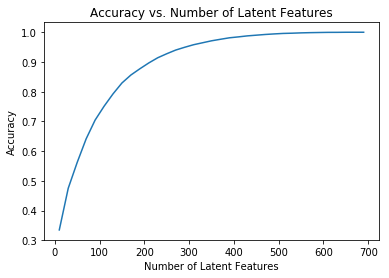

In [83]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [84]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [85]:
test_users_not_in_train = np.setdiff1d(test_idx,user_item_train.index.values)

In [86]:
test_users_not_in_train.shape

(662,)

In [87]:
test_idx.shape[0] - test_users_not_in_train.shape[0]

20

In [88]:
test_articles_not_in_train = np.setdiff1d(test_arts,user_item_train.columns.values)

In [89]:
test_articles_not_in_train.shape

(0,)

In [90]:
test_arts.shape[0] - test_articles_not_in_train.shape[0]

574

In [91]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many movies can we make predictions for in the test set?': b,# letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [92]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [93]:
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [94]:
user_item_train.tail()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
4483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4484,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4487,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
user_item_train.shape

(4487, 714)

In [96]:
test_users_in_train = np.intersect1d(test_idx,user_item_train.index.values)

In [97]:
test_users_in_train

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
       3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487])

In [98]:
u_train[test_users_in_train-1,:].shape

(20, 4487)

In [99]:
user_item_train.shape

(4487, 714)

In [100]:
user_item_test.loc[test_users_in_train]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3532,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3740,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
type(test_users_not_in_train)

numpy.ndarray

In [102]:
k=10
s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

In [103]:
print(u_new.shape, s_new.shape, vt_new.shape)

(4487, 10) (10, 10) (10, 714)


In [104]:
user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

In [105]:
print(user_item_est.shape)
user_item_est

(4487, 714)


array([[ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0., -0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [-0.,  0., -0., ..., -0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0., -0.]])

In [106]:
test_user_items_in_train = np.in1d(user_item_train.columns.values, user_item_test.columns.values).nonzero()[0]

In [107]:
print(test_user_items_in_train.shape)
test_user_items_in_train

(574,)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 167, 168, 169, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 18

In [108]:
test_user_item_est = user_item_est[(test_users_in_train-1)[:, None],test_user_items_in_train]

In [109]:
print(test_user_item_est.shape)
test_user_item_est

(20, 574)


array([[-0.,  0.,  0., ..., -0., -0.,  0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [-0.,  0.,  0., ..., -0., -0., -0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.]])

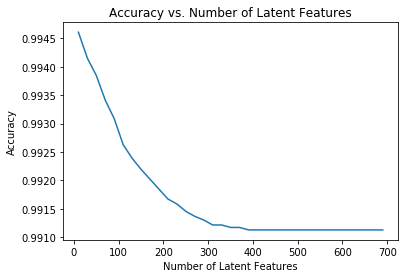

In [110]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
test_users_in_train_indices = np.intersect1d(test_idx,user_item_train.index.values)
test_user_articles_in_train = np.in1d(user_item_train.columns.values, user_item_test.columns.values).nonzero()[0]
filtered_user_item_test = user_item_test.loc[test_users_in_train_indices,:]

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # select subset of estimation matrix which comprises test intersection users/articles
    test_user_item_est = user_item_est[(test_users_in_train_indices-1)[:, None],test_user_articles_in_train]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(filtered_user_item_test, test_user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

As we can see in the above plot, the accuracy for the prediction of interactions between users and articles in the test set (considering only the subset which intersects with train set), the accuracy is always very high (over 99%) and the number of latent features does not influence that much. Thus, we could just keep the lower amount of the tested range (10).

In order to evaluate the actual improvement the recommendations developed in this notebook will have on how users currently find articles, we could design an A/B Testing, and check if the users receiving recommendations using the above techniques interact with the recommended articles, and if their overall level of interaction increases.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])